In [2]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("/path/to/repo/experiment_analysis/dat/")

2023-10-09 17:08:39,530 | INFO     | notebook | <module> | project directory: /Users/paul/para/2_Projects/information_timescales/repo/_latest/experiment_analysis


In [6]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_no_merging_all.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2023-10-09 17:11:16,432 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'image_selectivity_ns'] from /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2023-10-09 17:11:16,434 | DEBUG    | its_utility | load_metrics | Matched 12807 rows from meta_df in /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.027605,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.270567,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.039402,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.076247,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.032636,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.062859,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.081390,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.121748,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.105830,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723


In [9]:
# TODO: make these default preprocessing steps.

# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")

In [10]:
# we need a mapping from ephys acronyms to the names we use in the paper
structure_names = {
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

# TODO: dump the final, cleaned dataframe to disk again.

meta_df

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,structure_name
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN,AM
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN,AM
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN,AM
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN,AM
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018,RL
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999,RL
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331,RL
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723,RL


2023-10-09 17:14:43,009 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['8.0'] with 5951 rows
2023-10-09 17:14:45,842 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_one_more_repeats'] ['8.0'] with 5951 rows
2023-10-09 17:14:48,662 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_one_more_repeats'] ['8.0'] with 5951 rows


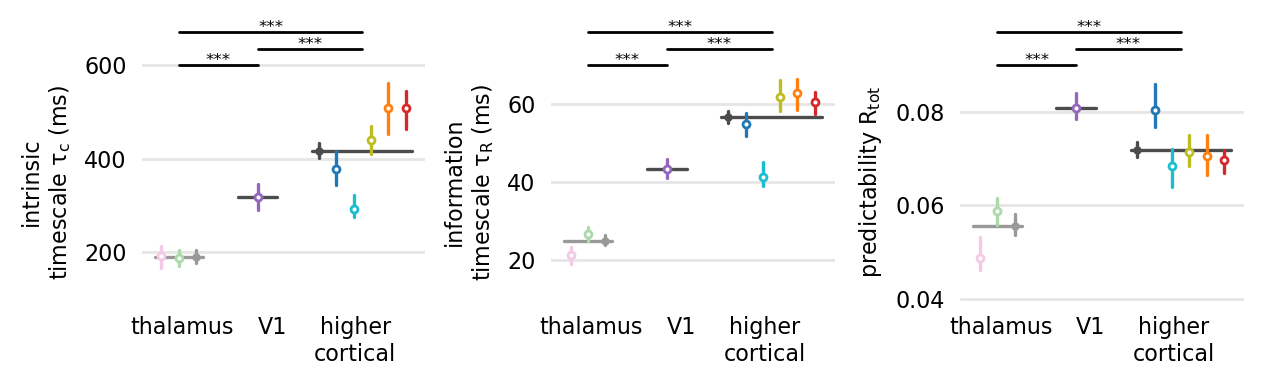

In [11]:
# Pick a block and plot the hierarchy.
# results should be consistent across blocks.

ph.log.setLevel("INFO")  # set to debug for p-values
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')")
ph.row_structure_groups(df);

2023-10-09 17:15:15,920 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['3.0'] with 5558 rows
2023-10-09 17:15:18,734 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_one_more_repeats'] ['3.0'] with 5558 rows
2023-10-09 17:15:21,529 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_one_more_repeats'] ['3.0'] with 5558 rows


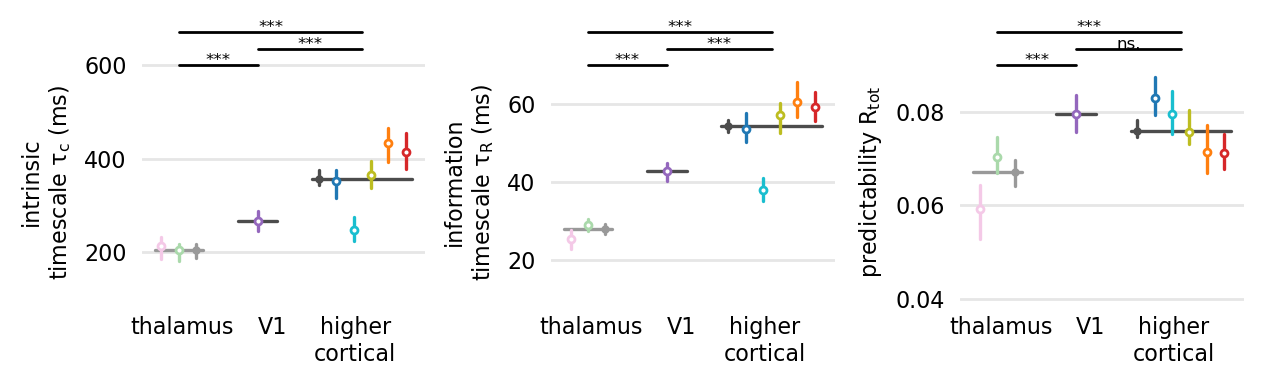

In [12]:
ph.log.setLevel("INFO") # set to debug for p-values
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')")
df = df.query("R_tot == R_tot")
df = df.query("tau_R == tau_R")
ph.row_structure_groups(df);

2023-10-09 17:15:48,833 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-10-09 17:15:48,836 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['8.0'] with 5089 rows
2023-10-09 17:15:50,354 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-10-09 17:15:50,357 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['8.0'] with 5089 rows
2023-10-09 17:15:51,856 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-10-09 17:15:51,859 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['8.0'] with 5089 rows


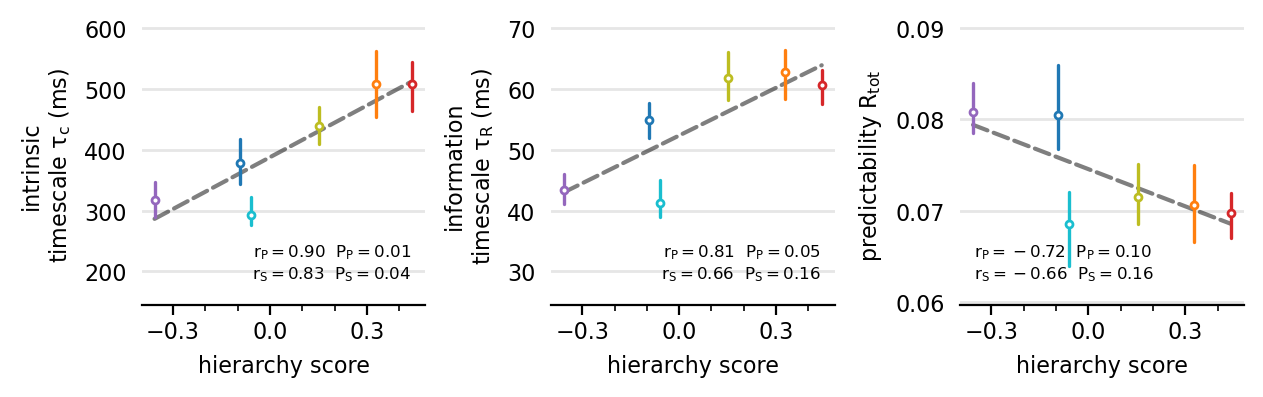

In [13]:
ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')")
ph.row_hierarchy_score(df);

2023-10-09 17:15:57,232 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-10-09 17:15:57,239 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['3.0'] with 4766 rows
2023-10-09 17:15:58,651 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-10-09 17:15:58,654 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['3.0'] with 4766 rows
2023-10-09 17:16:00,111 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-10-09 17:16:00,114 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['3.0'] with 4766 rows


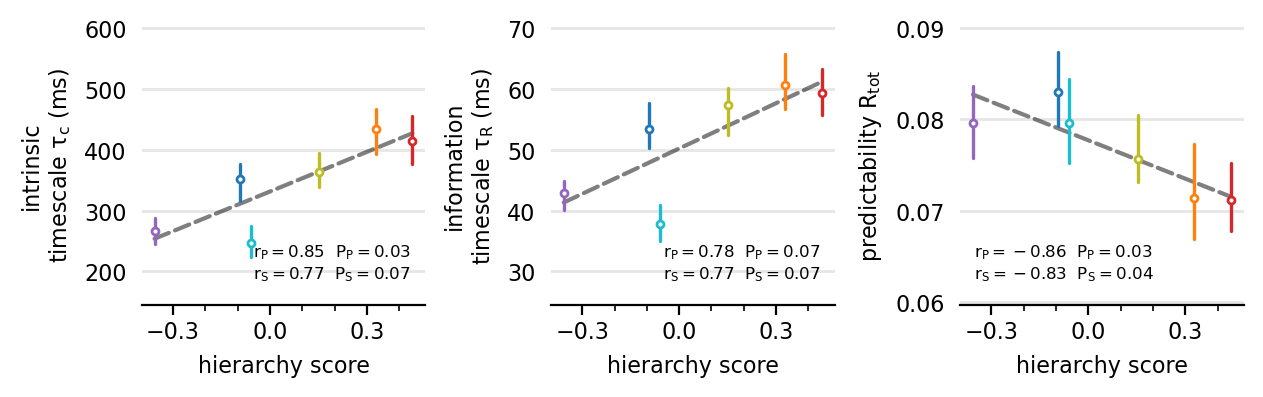

In [14]:
ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')")
ph.row_hierarchy_score(df);

In [15]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

scipy: 1.11.1

numpy         : 1.24.4
prompt_toolkit: 3.0.39
re            : 2.2.1
IPython       : 8.14.0
pandas        : 2.0.3
sys           : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
logging       : 0.5.1.2
h5py          : 3.9.0
sqlite3       : 2.6.0
matplotlib    : 3.7.2
xarray        : 2023.7.0
dask          : 2023.7.1

